# RSI momentum trading strategy example

- This is a backtest example notebook
    - This notebook is the part of the series of many, examining different configurations
    - We use `AlphaModel` to automatically reconstruct rebalances
    - The signal for the rebalance is is 0...1 per trading pair calculated

# Set up

Set up Trading Strategy data client.


In [11]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [12]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.d1,
    stop_loss_time_bucket=TimeBucket.h4,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 2, 15),
    include_lending=False
)


  0%|          | 0/2 [00:00<?, ?it/s]

# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [13]:
pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 3,744 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3797.14 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 139.1 at 2019-01-01 00:00:00


# Trading algorithm

In [14]:
from tradeexecutor.strategy.weighting import weight_equal, weight_by_1_slash_n, weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
import numpy as np
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradingstrategy.chain import ChainId
from typing import List, Dict

from pandas_ta.momentum import rsi
import pandas as pd

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.state.state import State

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

rsi_days = 5  # The length of RSI indicator
eth_btc_rsi_days = 5  # The length of ETH/BTC RSI
rsi_high = 70  # RSI trigger threshold for decision making
rsi_low = 30  # RSI trigger threshold for decision making
allocation = 0.95 # Allocate 90% of cash to each position
lookback_candles = 120
minimum_rebalance_trade_threshold = 500.00  # Don't do trades that would have less than 500 USD value change

def decide_trades(
    timestamp: pd.Timestamp,
    strategy_universe: TradingStrategyUniverse,
    state: State,
    pricing_model: PricingModel,
    cycle_debug_data: Dict
) -> List[TradeExecution]:

    # Resolve our pair metadata for our two pair strategy
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)
    alpha_model = AlphaModel(timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])

    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    close_prices = {btc_pair: None, eth_pair: None}  # Recent close prices
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:

        pair_candles = candles.get_last_entries_by_pair_and_timestamp(pair.internal_id, timestamp)
        close_prices[pair] = pair_candles["close"]

        assert pair_candles is not None
        rsi_series = rsi(pair_candles["close"], length=rsi_days)  # Will return None if the data buffer does not have enough days to look back

        # Reset indicators for this cycle and this pair
        current_rsi_values[pair] = None
        previous_rsi_values[pair] = None
        current_price[pair] = None
        price_today = None

        if len(pair_candles) > 0:
            # We have enough data to get the latest price
            current_price[pair] = price_today = pair_candles["close"][-1]

        if rsi_series is not None:
            current_val = rsi_series[-1]
            if np.isfinite(current_val):
                # We have enough data and good value for RSI
                assert 0 < current_val < 100, f"RSI sanity check failed: {pair}: {current_val}"  # Check we are in expected range
                current_rsi_values[pair] = current_val

            previous_val = rsi_series[-2]
            if np.isfinite(previous_val):
                # We have enough data and good value for RSI
                assert 0 < previous_val < 100, f"RSI sanity check failed: {pair}: {previous_val}"  # Check we are in expected range
                previous_rsi_values[pair] = previous_val

            previous_rsi_values[pair] = previous_val

    eth_btc_price = close_prices[eth_pair] / close_prices[btc_pair]
    eth_btc_rsi = rsi(eth_btc_price, length=eth_btc_rsi_days)
    if eth_btc_rsi is not None:
        eth_btc_rsi_yesterday = eth_btc_rsi[-1]
        momentum[eth_pair] = (eth_btc_rsi_yesterday - 50)
        momentum[btc_pair] = (50 - momentum[eth_pair])

    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:

        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            rsi_cross_above = current_rsi_values[pair] >= rsi_high and previous_rsi_values[pair] < rsi_high
            rsi_cross_below = current_rsi_values[pair] < rsi_low and previous_rsi_values[pair] > rsi_low

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength)
            else:
                # We have open position, check for the closure condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Equally weight for all assets that
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=minimum_rebalance_trade_threshold,
    )

    #
    # Visualisations
    #

    visualisation = state.visualisation  # Helper class to visualise strategy output

    visualisation.plot_indicator(
        timestamp,
        f"ETH",
        PlotKind.technical_indicator_detached,
        current_price[eth_pair],
        colour="blue",
    )

    # Draw BTC + ETH RSI between its trigger zones for this pair of we got a valid value for RSI for this pair

    # BTC RSI daily
    visualisation.plot_indicator(
        timestamp,
        f"RSI",
        PlotKind.technical_indicator_detached,
        current_rsi_values[btc_pair],
        colour="orange",
    )

    # ETH RSI daily
    visualisation.plot_indicator(
        timestamp,
        f"RSI ETH",
        PlotKind.technical_indicator_overlay_on_detached,
        current_rsi_values[eth_pair],
        colour="blue",
        label=PlotLabel.hidden,
        detached_overlay_name=f"RSI",
    )

    # Low (vertical line)
    visualisation.plot_indicator(
        timestamp,
        f"RSI low trigger",
        PlotKind.technical_indicator_overlay_on_detached,
        rsi_low,
        detached_overlay_name=f"RSI",
        plot_shape=PlotShape.horizontal_vertical,
        colour="red",
        label=PlotLabel.hidden,
    )

    # High (vertical line)
    visualisation.plot_indicator(
        timestamp,
        f"RSI high trigger",
        PlotKind.technical_indicator_overlay_on_detached,
        rsi_high,
        detached_overlay_name=f"RSI",
        plot_shape=PlotShape.horizontal_vertical,
        colour="red",
        label=PlotLabel.hidden,
    )

    if eth_btc_rsi_yesterday is not None:

        visualisation.plot_indicator(
            timestamp,
            f"ETH/BTC",
            PlotKind.technical_indicator_detached,
            eth_btc_price[-1],
            colour="grey",
        )

        if pd.notna(eth_btc_rsi_yesterday):
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

    state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    return trades

# Backtest

In [15]:
import logging
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="RSI multipair",
    engine_version="0.3",
    decide_trades=decide_trades,
    client=client,
    cycle_duration=CycleDuration.cycle_1d,
    universe=strategy_universe,
    initial_deposit=10_000,
    strategy_logging=False,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/161654400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 859 trades


# Alpha model thinking

- How did the alpha model decide on rebalnces

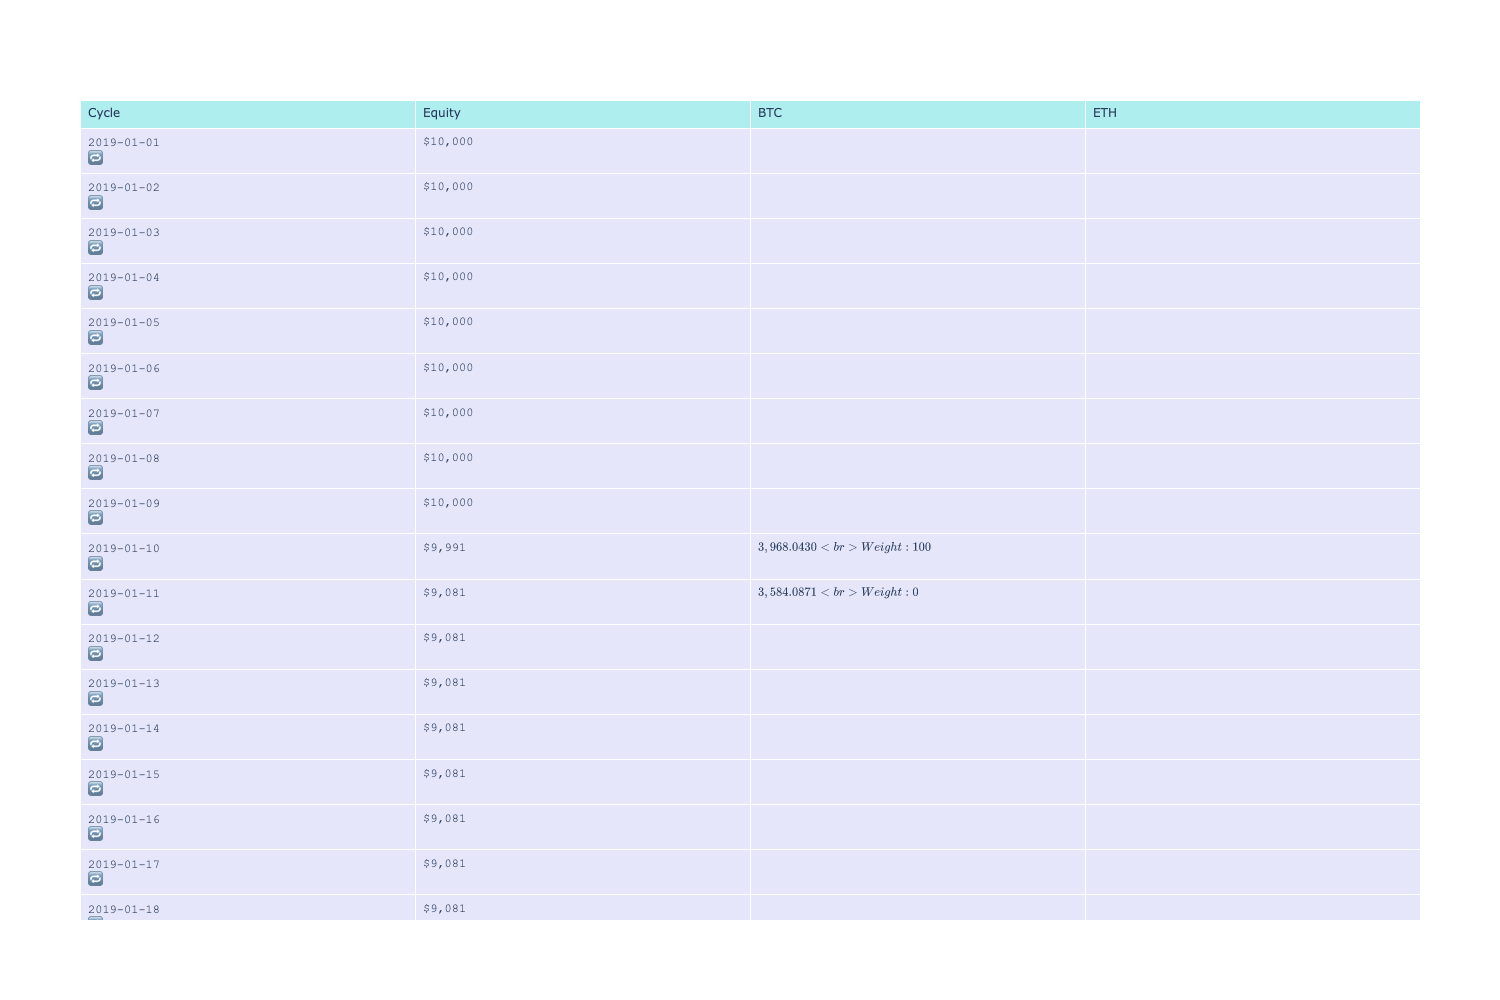

In [16]:
from tradeexecutor.analysis.alpha_model_analyser import render_alpha_model_plotly_table, create_alpha_model_timeline_all_assets

timeline = create_alpha_model_timeline_all_assets(state, universe, new_line="<br>")
figure, table = render_alpha_model_plotly_table(timeline)

figure.update_layout(
    autosize=True,
    height=800,)

display(figure)

# Indicators and trades

Visualise trades taken.

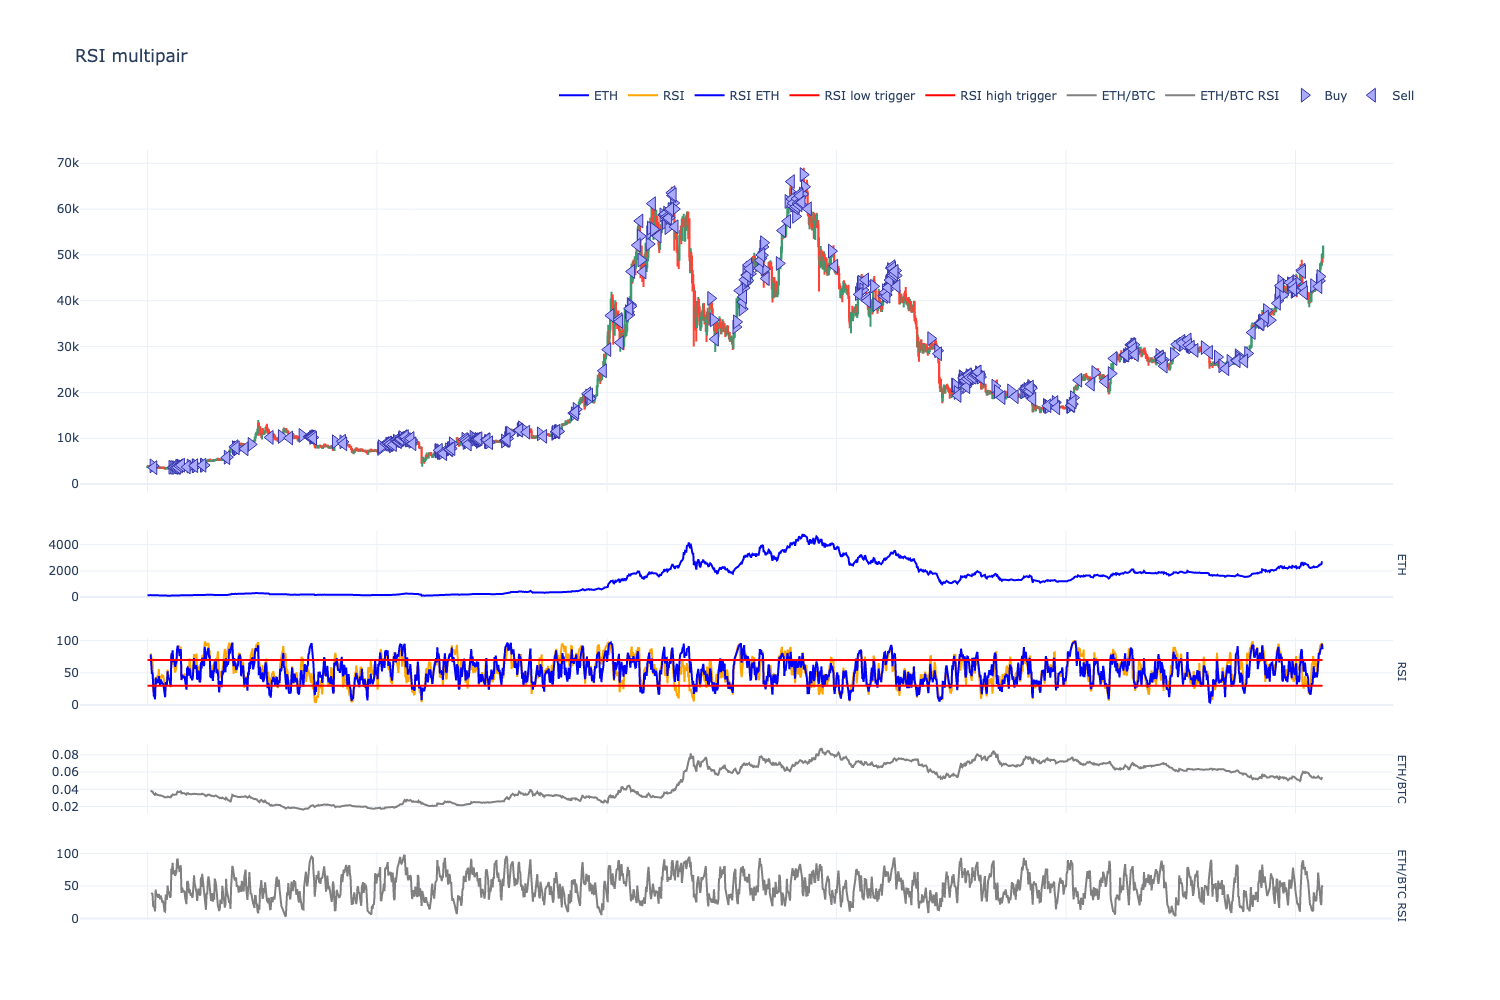

In [17]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

# Use BTC pair as the primary price source
# Get BTC pair
btc_pair = pairs.get_pair_by_human_description(our_pairs[0])

figure = visualise_single_pair(
    state,
    strategy_universe.data_universe.candles,
    pair_id=btc_pair.pair_id,
    volume_bar_mode=VolumeBarMode.hidden,
    height = 2000,
)

figure.show()

# Benchmark

Benchmark against

- Buy and hold BTC
- Buy and hold ETH

/var/folders/12/pbc59svn70q_9dfz1kjl3zww0000gn/T/ipykernel_88451/4046025580.py:13: DeprecationWarning:

This function is deprecated. Use visualise_equity_curve_benchmark instead



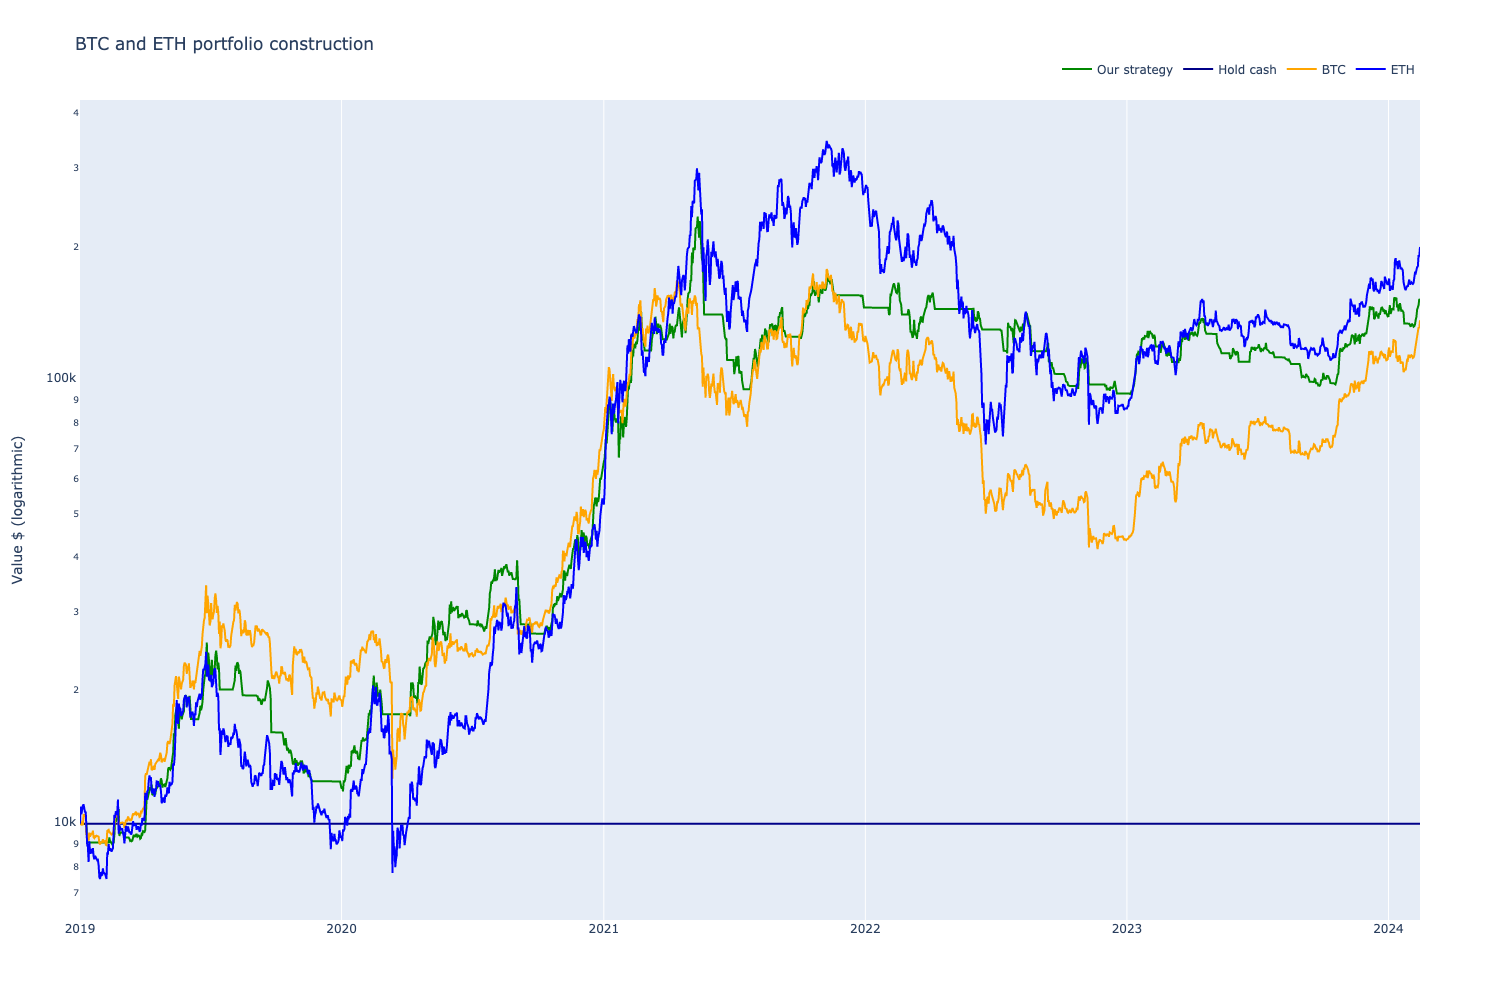

In [18]:
from tradeexecutor.visual.benchmark import visualise_benchmark

btc_pair = strategy_universe.data_universe.pairs.get_pair_by_human_description(our_pairs[0])
eth_pair = strategy_universe.data_universe.pairs.get_pair_by_human_description(our_pairs[1])

benchmark_indexes = pd.DataFrame({
    "BTC": strategy_universe.data_universe.candles.get_candles_by_pair(btc_pair)["close"],
    "ETH": strategy_universe.data_universe.candles.get_candles_by_pair(eth_pair)["close"],
})
benchmark_indexes["BTC"].attrs = {"colour": "orange", "name": "Buy and hold BTC"}
benchmark_indexes["ETH"].attrs = {"colour": "blue", "name": "Buy and hold ETH"}

fig = visualise_benchmark(
    name="Our strategy",
    title="BTC and ETH portfolio construction",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Performance metrics

Compare popular portfolio performance metrics.

- Benchmark the strategy against buy and hold ETH portfolio

In [19]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns, generate_buy_and_hold_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
benchmark_returns = generate_buy_and_hold_returns(benchmark_indexes["ETH"])

metrics = visualise_advanced_metrics(
    returns,
    mode=AdvancedMetricsMode.full,
    benchmark=benchmark_returns,
)

display(metrics)

Strategy Buy and hold ETH
Start Period               2019-01-01       2019-01-01
End Period                 2024-02-14       2024-02-14
Risk-Free Rate                   0.0%             0.0%
Time in Market                  67.0%           100.0%
Cumulative Return           1,415.58%        1,894.83%
CAGR﹪                          69.99%           79.36%
Sharpe                           1.23             1.12
Prob. Sharpe Ratio             99.72%           99.37%
Smart Sharpe                     1.17             1.07
Sortino                          1.88             1.64
Smart Sortino                     1.8             1.56
Sortino/√2                       1.33             1.16
Smart Sortino/√2                 1.27             1.11
Omega                            1.27             1.27
Max Drawdown                  -60.24%           -79.3%
Longest DD Days                  1007              827
Volatility (ann.)              56.14%           86.33%
R^2                               0.0              0.0
Information Ratio               -0.01            -0.01
Calmar                           1.16              1.0
Skew                             0.13            -0.37
Kurtosis                         10.5             8.87
Expected Daily                  0.15%            0.16%
Expected Monthly                4.48%            4.95%
Expected Yearly                57.31%           64.68%
Kelly Criterion                13.83%           12.18%
Risk of Ruin                     0.0%             0.0%
Daily Value-at-Risk            -4.64%           -7.17%
Expected Shortfall (cVaR)      -4.64%           -7.17%
Max Consecutive Wins                9               13
Max Consecutive Losses              7                8
Gain/Pain Ratio                  0.27             0.19
Gain/Pain (1M)                   1.53             1.34
Payoff Ratio                      1.4             1.22
Profit Factor                    1.27             1.19
Common Sense Ratio               1.49             1.32
CPC Index                        0.89             0.75
Tail Ratio                       1.18             1.11
Outlier Win Ratio                8.33             3.44
Outlier Loss Ratio               5.01             3.58
MTD                            14.04%           21.53%
3M                              20.6%           35.12%
6M                             36.27%           50.75%
YTD                             8.96%            21.6%
1Y                             27.33%           84.34%
3Y (ann.)                        5.3%           13.38%
5Y (ann.)                      76.71%           85.67%
10Y (ann.)                     69.99%           79.36%
All-time (ann.)                69.99%           79.36%
Best Day                       19.03%           26.33%
Worst Day                     -26.39%           -44.6%
Best Month                     53.54%           78.23%
Worst Month                   -24.55%          -44.85%
Best Year                     434.53%          470.16%
Worst Year                    -35.94%          -67.46%
Avg. Drawdown                  -8.46%          -13.66%
Avg. Drawdown Days                 40               44
Recovery Factor                  23.5            23.89
Ulcer Index                      0.38             0.46
Serenity Index                   1.73             2.36
Avg. Up Month                  18.94%           26.97%
Avg. Down Month                -8.83%           -16.3%
Win Days                       49.68%           51.82%
Win Month                      53.33%           64.52%
Win Quarter                    52.38%           71.43%
Win Year                       83.33%           66.67%
Beta                            -0.03                -
Alpha                            0.71                -
Correlation                    -4.15%                -
Treynor Ratio              -52438.74%                -

# Trading metrics

Trading-related metrics like fees.



In [20]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())